In [16]:
import graph_generator
import common
import pickle
import drawer

In [5]:
with open('clusters_results/2024_04_21/PARIS_11.pkl', 'rb') as f:
    paris :common.CityResult = pickle.load(f)
    f.close()

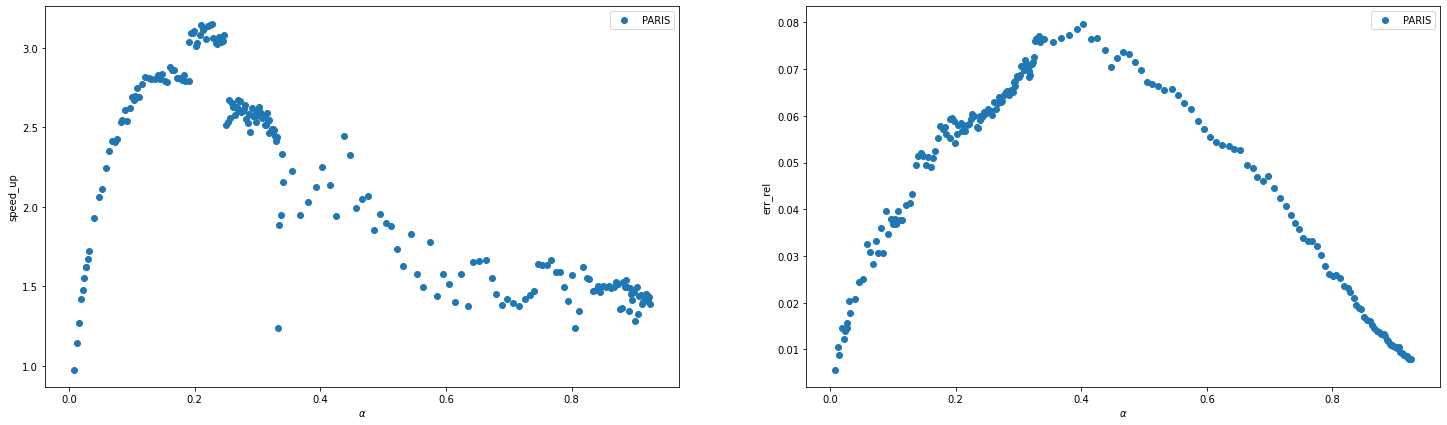

In [6]:

_, file = drawer.draw_few_city_result([paris])


In [2]:
from tqdm import trange

RESOLUTION = 270

H = graph_generator.get_graph('R71525')

In [3]:
print('generate points')
points = [graph_generator.get_node_for_initial_graph(H) for i in trange(1000)]

generate points


100%|██████████| 1000/1000 [01:12<00:00, 13.81it/s]


In [4]:
from tqdm import tqdm
import networkx as nx
import time
import tests

usual_results = [0, []]
start_time = time.time()

for node_from, node_to in tqdm(points):
    usual_path = nx.single_source_dijkstra(H, node_from, node_to, weight='length')
    usual_results[1].append(usual_path[0])

end_time = time.time()
usual_time = end_time - start_time
usual_results[0] = usual_time
print(usual_time)

result = common.CityResult(
    name='TEST_PARIS',
    name_suffix='',
    city_id='R71525',
    nodes=len(H.nodes),
    edges=len(H.edges)
)

tmp = tests.test_layer(H, RESOLUTION, usual_results, points, True)
result.points_results.append(tmp)

100%|██████████| 1000/1000 [00:42<00:00, 23.43it/s]


42.689515829086304


In [5]:

import numpy as np
from common import CentroidResult

point_result : CentroidResult = result.points_results[0]

print(point_result.speed_up)
i = np.argmax(point_result.errors)
f,t = points[i]
print(max(point_result.errors))
print(min(point_result.errors))


[3.1086833705703953]
0.31248000412676435
0.0


In [6]:
communities = graph_generator.resolve_communities(H, RESOLUTION)

In [15]:
print(communities)

[{361704, 480690113, 360930, 15035558}, {360978, 36480662, 88197671, 8579744905, 36476892}, {166449440, 29414561, 166452641, 166450259, 244455597, 360990}, {14798307, 10733009382, 988246569, 34818762, 166452976, 988247027, 34818712, 34818713, 360991}, {177268978, 177268309, 295135510, 361000, 361001, 295136206}, {26588374, 361031, 361032, 26588376, 26588378, 26588366, 247352879}, {2249340457, 2249340458, 21648012, 21648333, 6194686158, 3920493837, 361045, 21648535, 21648536, 21648537, 929489083, 21648349, 247756542}, {1134402753, 27308705, 361059, 361060, 25034403, 25031493, 25032939, 25031252, 7847045368, 25101533}, {26400923, 26401412, 26400917}, {94165798, 11021749522, 25095565, 361102}, {361120, 8968377858, 5291668659, 94243625, 260419337, 272678970, 361117}, {15435232, 245225569, 15435234, 6867489635, 1836902820, 361735, 361706, 361721, 15435230, 15435231}, {24972423, 24984073, 367506, 470131, 25095604, 25095606, 25095608, 24972382}, {11070910848, 361062, 367510, 25095799}, {27117

In [49]:
from map_drawer import draw_on_map
from folium import folium
from graph_generator import resolve_communities
import graph_generator

path = nx.dijkstra_path(H, f,t, weight='length')
clusters = set()
for node in path:
    clusters.add(H.nodes[node]['cluster'])
G = graph_generator.extract_cluster_list_subgraph(H, clusters)

In [50]:

P = nx.Graph()
for node in path:
    P.add_node(node, **H.nodes[node])
for i in range(len(path) - 1):
    P.add_edge(path[i], path[i+1],**H[path[i]][path[i+1]])

In [10]:
from graph_generator import generate_layer

layer = generate_layer(H, RESOLUTION)


In [11]:
from pfa import find_path

print(f ,t )
my_path = find_path(layer, f, t, True)

clusters = set()
for node in my_path[1]:
    clusters.add(H.nodes[node]['cluster'])
my_G = graph_generator.extract_cluster_list_subgraph(H, clusters)
my_P = nx.Graph()

for node in my_path[1]:
    my_P.add_node(node, **H.nodes[node])
for i in range(len(my_path[1]) - 1):
    my_P.add_edge(my_path[1][i], my_path[1][i+1],**H[my_path[1][i]][my_path[1][i+1]])

227073732 320153268


In [13]:
import webbrowser
map: folium.Map = draw_on_map(G,communities=communities)
map = draw_on_map(my_G, communities=communities, m = map)
map = draw_on_map(P, node_colors='white', m = map)
map = draw_on_map(my_P, node_colors='red', m = map)

map.save("map.html")
webbrowser.open("map.html")

True

In [47]:
print(my_path[0])

7192.529000000002


In [14]:
import betta_variation

VARIATION_RESOLUTION = 980
procent = 0.0006

rad = round(len(H.nodes()) * procent)
Var_G = betta_variation.variation(H, rad)
var_comm = resolve_communities(Var_G, VARIATION_RESOLUTION)


variation: 100%|██████████| 9574/9574 [00:00<00:00, 17508.79it/s]


In [39]:

def find_path1(
        layer: common.GraphLayer,
        from_node: int,
        to_node: int,
        neighbour_cluster=False) -> tuple[float, list[int]]:
    from_d = layer.graph.nodes[from_node]
    to_d = layer.graph.nodes[to_node]

    from_cluster = from_d['cluster']
    to_cluster = to_d['cluster']

    if from_cluster == to_cluster:
        return nx.single_source_dijkstra(graph_generator.extract_cluster_subgraph(layer.graph, to_cluster), from_node, to_node,
                                         weight='length')

    from_center = layer.cluster_to_center[from_cluster]
    to_center = layer.cluster_to_center[to_cluster]

    path = nx.bidirectional_dijkstra(
        layer.centroids_graph,
        from_center,
        to_center,
        weight='length')

    cls = set()

    for u in path[1]:
        c = layer.graph.nodes[u]['cluster']
        cls.add(c)
        if neighbour_cluster:
            for to in layer.cluster_to_neighboring_cluster[c]:
                cls.add(to)
    g = graph_generator.extract_cluster_list_subgraph(layer.graph, cls)
    return nx.bidirectional_dijkstra(
        g,
        from_node,
        to_node,
        weight='length')


In [45]:
H_1 = H.copy()
print(len(var_comm))
for i,us in enumerate(var_comm):
    for u in us:
        H_1.nodes[u]['cluster'] = i

layer = graph_generator.generate_layer(Var_G, RESOLUTION, communities = var_comm)


3566


In [54]:
var_result = common.CityResult(
    name='TEST_PARIS',
    name_suffix='',
    city_id='R71525',
    nodes=len(Var_G.nodes),
    edges=len(Var_G.edges)
)

tmp = tests.test_layer(Var_G, RESOLUTION, usual_results, points, True)
var_result.points_results.append(tmp)

In [56]:

import numpy as np
from common import CentroidResult

point_result : CentroidResult = var_result.points_results[0]

print(point_result.speed_up)
i = np.argmax(point_result.errors)
f,t = points[i]
print(max(point_result.errors))
print(min(point_result.errors))
print(f,t)


[0.8125716934085317]
0.30584924751751236
1.0454102209194689e-05
25255912 14950172


In [57]:
my_path = find_path1(layer, f, t, True)

clusters = set()
for node in my_path[1]:
    clusters.add(Var_G.nodes[node]['cluster'])
my_G = graph_generator.extract_cluster_list_subgraph(Var_G, clusters)
my_P = nx.Graph()

for node in my_path[1]:
    my_P.add_node(node, **Var_G.nodes[node])
for i in range(len(my_path[1]) - 1):
    my_P.add_edge(my_path[1][i], my_path[1][i+1],**Var_G[my_path[1][i]][my_path[1][i+1]])


NodeNotFound: Either source 25255912 or target 14950172 is not in G

In [51]:
map: folium.Map = draw_on_map(G,communities=communities)
map = draw_on_map(my_G, communities=communities, m = map)
map = draw_on_map(P, node_colors='white', m = map)
map = draw_on_map(my_P, node_colors='red', m = map)

map.save("map.html")
webbrowser.open("map.html")

True